# RAG Data Valuation: Real-World Benchmark (SQuAD)
This notebook performs a real-world benchmark using the SQuAD v2 dataset. It compares a **Baseline RAG** (using all retrieved chunks) against a **DV-Enhanced RAG** (filtering out chunks with negative Data Valuation scores).

In [4]:

import sys
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from typing import List, Dict

# Add src to path
sys.path.append(os.path.abspath('../../'))

from src.dv.models.entities import Chunk, ValuationMethod, ExperimentRun
from src.dv.algorithms.loo import LOOValuator
from src.dv.evaluation.judges import MNLIJudge
from src.dv.core import ValuationSuite
from src.rag.chunking.recursive import recursive_chunker
from src.dv.evaluation.filtering import filter_negative_chunks


## 1. Load Real Dataset (SQuAD v2)
Taking a small subset for demonstration purposes.

In [5]:

# Load SQuAD v2
dataset = load_dataset("squad_v2", split="train", streaming=True)
samples = list(dataset.take(10))

# Preprocess samples into RAG format
rag_data = []
for i, s in enumerate(samples):
    context = s['context']
    question = s['question']
    # If no answers, it's an unanswerable question in SQuAD v2
    if len(s['answers']['text']) > 0:
        answer = s['answers']['text'][0]
    else:
        answer = "No answer available in context."
        
    # Chunk the context
    chunks = recursive_chunker(context, chunk_size=300)
    
    rag_data.append({
        "query": question,
        "answer": answer,
        "chunks": chunks
    })

print(f"Loaded {len(rag_data)} samples from SQuAD v2.")


Loaded 10 samples from SQuAD v2.


## 2. Running the Benchmark
We evaluate the faithfulness of the answer given:
1. **Baseline**: All chunks extracted from the context.
2. **DV-Filtered**: Only chunks with positive (or zero) LOO scores.

In [6]:

# Initialize components
judge = MNLIJudge()
suite = ValuationSuite({"LOO": LOOValuator(judge)})

results = []

for item in rag_data:
    query = item["query"]
    answer = item["answer"]
    chunks = item["chunks"]
    
    # Baseline Faithfulness (All chunks)
    full_context = " ".join([c.text for c in chunks])
    baseline_faithfulness = judge.get_faithfulness(query, full_context, answer)
    
    # Compute Data Valuation
    dv_reports = suite.evaluate_all(query, chunks, answer)
    
    # DV-Filtered context
    filtered_chunks = filter_negative_chunks(chunks, dv_reports)
    filtered_context = " ".join([c.text for c in filtered_chunks])
    
    # If filtered context is empty, fallback to full (or handle as 0)
    if not filtered_context:
        dv_faithfulness = baseline_faithfulness
    else:
        dv_faithfulness = judge.get_faithfulness(query, filtered_context, answer)
    
    results.append({
        "query": query,
        "baseline_faith": baseline_faithfulness,
        "dv_faith": dv_faithfulness,
        "chunks_removed": len(chunks) - len(filtered_chunks)
    })

benchmark_df = pd.DataFrame(results)
benchmark_df['improvement'] = benchmark_df['dv_faith'] - benchmark_df['baseline_faith']
benchmark_df


Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use mps


,query,baseline_faith,dv_faith,chunks_removed,improvement
0,When did Beyonce start becoming popular?,0.505163,0.505163,0,0.000000
1,What areas did Beyonce compete in when she was...,0.436694,0.436694,3,0.000000
2,When did Beyonce leave Destiny's Child and bec...,0.436397,0.440156,1,0.003760
3,In what city and state did Beyonce grow up?,0.392086,0.392086,3,0.000000
4,In which decade did Beyonce become famous?,0.449107,0.484958,1,0.035851
5,In what R&B group was she the lead singer?,0.403123,0.518557,2,0.115434
6,What album made her a worldwide known artist?,0.460004,0.487713,2,0.027709
7,Who managed the Destiny's Child group?,0.407496,0.558602,2,0.151106
8,When did Beyoncé rise to fame?,0.449107,0.484958,1,0.035851
9,What role did Beyoncé have in Destiny's Child?,0.367358,0.367358,3,0.000000


## 3. Results Summary
Measuring the impact of Data Valuation on RAG faithfulness.

Average Baseline Faithfulness: 0.4307
Average DV-Enhanced Faithfulness: 0.4676
Average Improvement: 0.0370


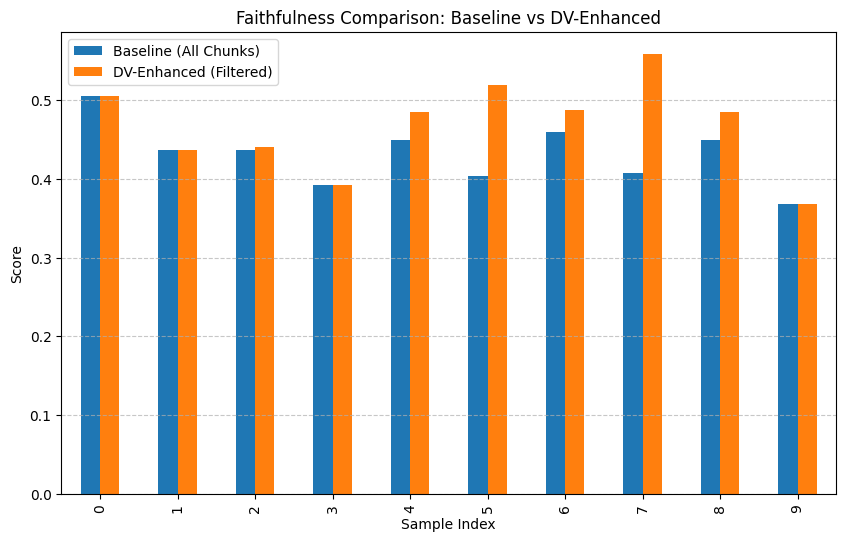

Summary: 6 Wins, 0 Losses, 4 Ties


In [7]:

avg_baseline = benchmark_df['baseline_faith'].mean()
avg_dv = benchmark_df['dv_faith'].mean()
total_improvement = benchmark_df['improvement'].mean()

print(f"Average Baseline Faithfulness: {avg_baseline:.4f}")
print(f"Average DV-Enhanced Faithfulness: {avg_dv:.4f}")
print(f"Average Improvement: {total_improvement:.4f}")

# Plotting
plt.figure(figsize=(10, 6))
benchmark_df[['baseline_faith', 'dv_faith']].plot(kind='bar', ax=plt.gca())
plt.title("Faithfulness Comparison: Baseline vs DV-Enhanced")
plt.xlabel("Sample Index")
plt.ylabel("Score")
plt.legend(["Baseline (All Chunks)", "DV-Enhanced (Filtered)"])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Win/Loss/Tie Ratio
wins = len(benchmark_df[benchmark_df['improvement'] > 0])
losses = len(benchmark_df[benchmark_df['improvement'] < 0])
ties = len(benchmark_df[benchmark_df['improvement'] == 0])

print(f"Summary: {wins} Wins, {losses} Losses, {ties} Ties")
